In [1]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import *
import sklearn
import math
import os
import random
import sys
import multiprocessing
import scipy
from joblib import Parallel, delayed
import threading
nproc = max(1, multiprocessing.cpu_count() - 1)

if 'utils' not in sys.path:
    sys.path.append('utils')

import data_loader
from tf_gmm_em import *

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Idempotent, cached data retrieval script

print(data_loader.load_chromosome.__doc__)
train_df, test_df, train_ix, test_ix, train_tissues, tfs = \
    data_loader.load_chromosome_cached('1')

Idempotent data loading. For a given chromosome n (a string).
    
    Returns (train_df, test_df, train_ix, test_ix, train_tissues, tfs)
    
    The first two are the train and test dataframes, and test_ix are the
    values in test_df['assayed'] that are missing and need to be imputed (with the
    correct answer being in test_df['filled'] in the corresponding locations.
    train_ix are the assayed (known) methylation values from limited microarray
    sampling (e.g., test_df['assayed'].iloc[train_ix] can be used for prediction of
    test_df['filled'].iloc[test_ix], and the former should be about equal to
    test_df['filled'].iloc[train_ix] (two different ways of sampling methylation).
    
    Imports genetic context and adds those columns to the parameter df, returning
    a merged one. tfs is the list of names of new transcription
    factors.
    
    train_tissues is a list of the names of columns with chromosome methylation values.
    
    Note that loading from scratch ma

In [2]:
prefix = '/n/fs/cyc424/sjayanti/final-proj-cos-424/data/'
arg_k = np.arange(2,15)

best_params = {}
for estimate in ('mle', 'argmax'):
    best_k_r2 = -np.inf, None
    for epsilon in ('eps', '0.001'):
        for k in arg_k:
            filename = prefix + 'cv-'+str(k)+'-'+estimate+'-'+epsilon+'.p_r2.npy'
            if not os.path.isfile(filename): continue
            mean = np.median(np.load(filename))
            best_k_r2 = max(best_k_r2, (mean, k, epsilon))
    best_params[estimate] = best_k_r2
highest = {} 
for k, v in best_params.items():
    mean, best_k, epsilon = v
    ls = []
    for K in arg_k:
        filename = prefix + 'cv-'+str(K)+'-'+k+'-'+epsilon+'.p_r2.npy'
        if not os.path.isfile(filename): continue
        mean = np.median(np.load(filename))
        ls.append((K, mean))
    Ks, means = zip(*ls)
    Ks, means = np.array(Ks), np.array(means)
    print('Epsilon for', k, '=', epsilon, '; best K =', best_k, '; mean =', mean)
    highest[k] = (Ks, means)

best_params_tuple = max(best_params.items(), key=lambda x: x[1][1])
best_params = {'method': best_params_tuple[0],
               'min_covar': float(best_params_tuple[1][2]),
               'K': best_params_tuple[1][1]}
print('best_parameter set', best_params)

Epsilon for mle = 0.001 ; best K = 8 ; mean = 0.677064817382
Epsilon for argmax = 0.001 ; best K = 10 ; mean = 0.675767406197
best_parameter set {'method': 'argmax', 'K': 10, 'min_covar': 0.001}


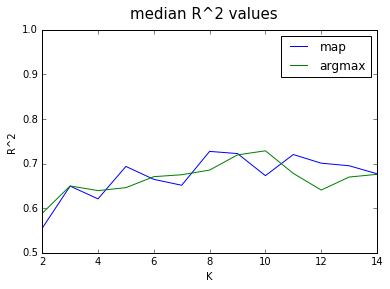

In [3]:
def plotR2(r2dict):
    mles = r2dict['mle'][1]
    amxs = r2dict['argmax'][1]
    Km = r2dict['mle'][0]
    Ka = r2dict['argmax'][0]

    # It's actually a MAP
    plt.plot(Km, mles, label='map')
    plt.plot(Ka, amxs, label='argmax')
    plt.suptitle('median R^2 values', fontsize=15)
    plt.ylabel('R^2')
    plt.xlabel('K')
    plt.legend()
    plt.axis([2,14,0.5,1])
    plt.show()

plotR2(highest)

In [4]:
train_df_int = train_df
for i in train_tissues:
    train_df_int[i] = data_loader.local_impute(train_df[i].copy())
tissues_to_cluster = train_tissues[:]
for i in [14, 25, 26, 33]:
    tissues_to_cluster.remove('b' + str(i))
X_np = train_df_int[tissues_to_cluster].values.transpose()
print(X_np.shape)
X_np_new = X_np
print(X_np_new.shape)

(30, 379551)
(30, 379551)


In [5]:
# Fix a value of K. Perform NUM_RESTARTS random restarts, and pick EM fit with highest mean likelihood 
# X_np_new = data matrix with bad samples deleted.
# X_perm   = permute(X_np_new)
# NUM_RESTARTS = number of random restarts

NUM_RESTARTS = 10

def get_permutation():
    o = np.ones(len(train_df))
    o[train_ix] = 0
    o[test_ix] = 0
    unobserved_untested_ix = np.where(o)[0]
    o = np.zeros(len(train_df))
    o[test_ix] = 1
    unobserved_tested_ix = np.where(o)[0]
    permutation = np.hstack((train_ix, unobserved_tested_ix, unobserved_untested_ix))
    return permutation, unobserved_tested_ix, unobserved_untested_ix

def fit_model(X_train, unobserved_tested_ix, unobserved_untested_ix):
    if best_params['method'] != 'argmax': raise Exception('Only MLE implemented')
    N = X_train.shape[0]
    tf.reset_default_graph()
    lp = None
    m = None
    s = None
    a = None
    for j in range(NUM_RESTARTS):
        print('  running restart {}/{}'.format(j + 1, NUM_RESTARTS))
        rmu = np.random.choice(range(X_train.shape[0]), best_params['K'], replace=False)
        mu_init = X_train[rmu]
        cur_lp, cur_m, cur_s, cur_a = fit_em(X_train, mu_init, 100, EPS, best_params['min_covar'])
        if lp is None or cur_lp > lp:
            lp = cur_lp
            m = cur_m
            s = cur_s
            a = cur_a
    print("Done picking best EM")
    ''' 
    all_alphas = np.zeros((K, N))
    for sample in range(N):
        X_test = X_train[sample, :]
        observed = X_test
        marginal_means, marginal_covs, marginal_alphas = marginal_posterior(observed.reshape(1, len(observed)), m, s, a)
        all_alphas[:, sample] = marginal_alphas.transpose()[:,0]
    '''      
    
    observed = test_df['filled'][train_ix].values
    marginal_means, marginal_covs, marginal_alphas = marginal_posterior(observed.reshape(1, len(observed)), m, s, a)
    
    pred = argmax_exp(marginal_means, marginal_covs, marginal_alphas[0])[:len(unobserved_tested_ix)]
    actual = test_df['filled'][unobserved_tested_ix]
    print(len(pred), len(actual))
    rmse = sklearn.metrics.mean_squared_error(actual, pred)
    print('rmse', np.sqrt(rmse)) # rmse of GMM
    r2 = sklearn.metrics.r2_score(actual, pred)
    print('r2', r2)
    return marginal_means, marginal_covs, marginal_alphas, lp, m, s, a

perm, unobserved_tested_ix, unobserved_untested_ix = get_permutation()
X_perm = X_np_new[:, perm]

print("K", best_params['K'])
print("NUM_RESTARTS", NUM_RESTARTS)
print("X_perm.shape", X_perm.shape) 

#KxN responsibilities
marginal_means, marginal_covs, marginal_alphas, marginal_logp, mus, sigs, alphas = \
    fit_model(X_perm, unobserved_tested_ix, unobserved_untested_ix)

K 10
NUM_RESTARTS 10
X_perm.shape (30, 379551)
  running restart 1/10
  running restart 2/10
  running restart 3/10
  running restart 4/10
  running restart 5/10
  running restart 6/10
  running restart 7/10
  running restart 8/10
  running restart 9/10
  running restart 10/10
Done picking best EM
368411 368411
rmse 0.0706916443231
r2 0.825237816805


In [6]:
with tf.Session() as sess:
    resp = sess.run(estep(X_perm, mus, sigs, alphas)[1])
print(resp.shape)

(10, 30)


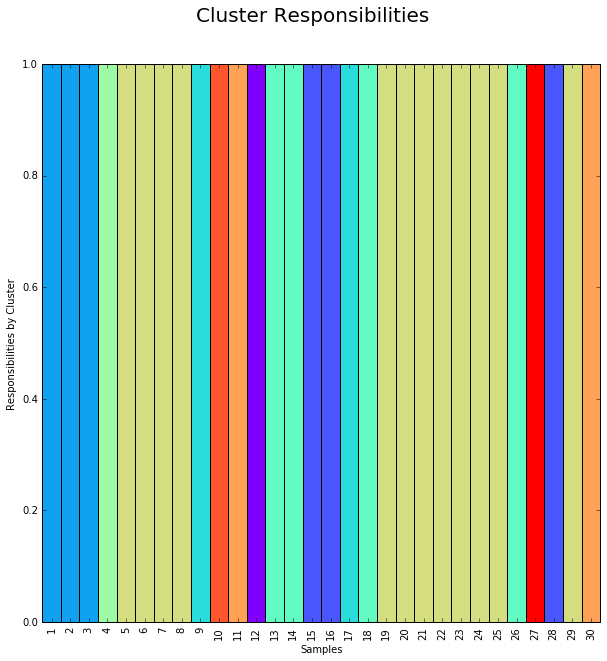

In [7]:
def plotbar(resp):
    f = plt.figure(figsize=(10,10))
    K = resp.shape[0]
    N = resp.shape[1]

    sample_interval = [i for i in range(N)]
    running_sum = np.zeros(N)
    color_vec = plt.cm.rainbow(np.linspace(0, 1, K))
    for i in range(resp.shape[0]):
        plt.bar(sample_interval, resp[i,:], width=1.0, color = color_vec[i], bottom = running_sum)
        running_sum = running_sum + resp[i,:]
    plt.suptitle('Cluster Responsibilities', fontsize=20)
    plt.ylabel('Responsibilities by Cluster')
    plt.xlabel('Samples')
    plt.axis([0,N,0,1])
    #plt.legend(handles=[mplot, aplot])
    x = [i+0.5 for i in range(N)]
    labels = [i+1 for i in range(N)]
    plt.xticks(x, labels, rotation='vertical')
    plt.show()

plotbar(resp)

In [8]:
def KL(mu1, mu2, sigma1, sigma2):
    logsum1 = np.sum(np.log(sigma1))
    logsum2 = np.sum(np.log(sigma2))
    detS1 = np.prod(sigma1)
    detS2 = np.prod(sigma2)

    d = len(mu1)
    
    invS2 = [1/x for x in sigma2]
    trInvS2S1 = np.sum([x1*x2 for x1, x2 in zip(invS2, sigma1)])
    
    mu2MinusMu1 = [x-y for x,y in zip(mu2,mu1)]
    lastTerm = np.sum([x1*x2*x3 for x1, x2, x3 in zip(mu2MinusMu1, invS2, mu2MinusMu1)])
    
    kl = (1/2)*(logsum2-logsum1 - d + trInvS2S1 + lastTerm)
    #kl = (1/2)*(np.log(detS2/detS1) - d + trInvS2S1 + lastTerm)
    return kl
    
def sym_KL(mu1, mu2, sigma1, sigma2):
    kl1 = KL(mu1, mu2, sigma1, sigma2)
    kl2 = KL(mu2, mu1, sigma2, sigma1)
    return kl1 + kl2
    
print(KL([1,1],[0,0],[1,1],[1,1]))
print(sym_KL([1,1],[0,0],[1,1],[1,1]))

1.0
2.0


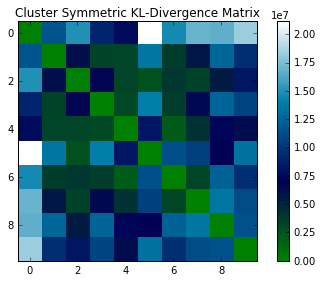

In [9]:
np.seterr(all='raise')
def plot_KL(mu, sigma):
    K = len(mu)
    kl_mat = [[sym_KL(mu[i], mu[j], sigma[i], sigma[j]) for i in range(K)] for j in range(K)]
    #print(kl_mat)
    plt.imshow(kl_mat, interpolation='nearest', cmap=plt.cm.ocean)
    plt.title('Cluster Symmetric KL-Divergence Matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_KL(mus, sigs)

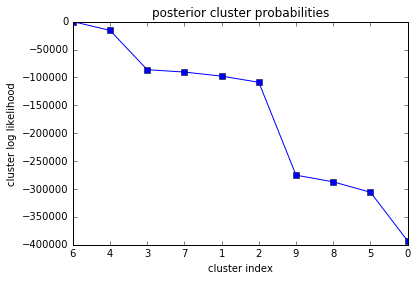

Note that the next most likely cluster has a log likelihood of (-15734.979391208079, 4), still very small


In [10]:
ma = marginal_alphas.reshape(-1)
sa = sorted(list(zip(ma.reshape(-1), range(len(ma)))), reverse=True)
vals, labels = zip(*sa)

plt.plot(vals, 'bs-')
plt.xticks(range(len(ma)), labels)
plt.title('posterior cluster probabilities')
plt.ylabel('cluster log likelihood')
plt.xlabel('cluster index')
plt.show()
print('Note that the next most likely cluster has a log likelihood of {}, still very small'.format(sa[1]))

In [11]:
best_label = labels[0]
print('best label', best_label)
bmu = marginal_means[best_label]
bsigma = np.sqrt(marginal_covs[best_label])
print(bmu.shape, bsigma.shape)
l = len(unobserved_tested_ix)
bmu_cut, bsigma_cut = bmu[:l], bsigma[:l]
actual = test_df['filled'][unobserved_tested_ix]
lo = bmu_cut - 2 * bsigma_cut
hi = bmu_cut + 2 * bsigma_cut
print(bmu_cut.mean(), actual.mean())
inside = (lo <= actual) & (actual <= hi)
print(inside.shape)
print('ratio inside', inside.sum() / len(inside))

best label 6
(372028,) (372028,)
0.798886498167 0.802382611075
(368411,)
ratio inside 0.97766624775
